# Accès aux soins de santé - Rapport

## Proportion de la population vivant dans un rayon de 5 km autour d'un établissement de soins de santé (environ 60 minutes à pied)

In [1]:
#%% Clean environment & global settings

options(scipen=999)

# Sys.setenv(PROJ_LIB = "/opt/conda/share/proj")
# Sys.setenv(GDAL_DATA = "/opt/conda/share/gdal")

In [2]:
#%% File paths

ROOT_PATH <- '~/workspace'
PROJECT_PATH <- file.path(ROOT_PATH, "pipelines/snt_healthcare_access")
CONFIG_PATH <- file.path(ROOT_PATH, 'configuration')
CODE_PATH <- file.path(ROOT_PATH, 'code')
DATA_PATH <- file.path(ROOT_PATH, 'data')
DHIS2_DATA_PATH <- file.path(DATA_PATH, 'dhis2', 'formatted')
OUTPUT_DATA_PATH <- file.path(DATA_PATH, 'healthcare_access')
OUTPUT_PLOTS_PATH <- file.path(PROJECT_PATH, 'reporting', 'outputs')

In [3]:
#%% Load utils, config and libraries
source(file.path(CODE_PATH, "snt_utils.r"))

# Required packages
required_packages <- c(
  "jsonlite",
  "dplyr",
  "data.table",
  "ggplot2",
  "arrow",
  "glue",
  # "geojsonio",
  "sf",
  "terra",
  "RColorBrewer",
  "httr",
  "reticulate",
  "arrow"
)

# Execute function
install_and_load(required_packages)

Sys.setenv(RETICULATE_PYTHON = "/opt/conda/bin/python")
reticulate::py_config()$python
openhexa <- import("openhexa.sdk")

# Load SNT config
CONFIG_FILE_NAME <- "SNT_config.json"
config_json <- tryCatch({ fromJSON(file.path(CONFIG_PATH, CONFIG_FILE_NAME)) },
                        error = function(e) {
                          msg <- paste0("Error while loading configuration", conditionMessage(e))  
                          cat(msg)   
                          stop(msg) 
                        })

msg <- paste0("SNT configuration loaded from  : ", file.path(CONFIG_PATH, CONFIG_FILE_NAME)) 
log_msg(msg)

            jsonlite                dplyr           data.table 
    "jsonlite 1.8.9"        "dplyr 1.1.4"  "data.table 1.17.8" 
             ggplot2                arrow                 glue 
     "ggplot2 3.5.2"       "arrow 18.1.0"         "glue 1.7.0" 
                  sf                terra         RColorBrewer 
         "sf 1.0.20"       "terra 1.8.42" "RColorBrewer 1.1.3" 
                httr           reticulate                arrow 
        "httr 1.4.7"  "reticulate 1.44.1"       "arrow 18.1.0" 


[1] "/opt/conda/bin/python"

[1] "SNT configuration loaded from  : ~/workspace/configuration/SNT_config.json"


In [4]:
#%% Config variables

COUNTRY_CODE <- config_json$SNT_CONFIG$COUNTRY_CODE
print(paste("Country code: ", COUNTRY_CODE))

dhis2_dataset <- config_json$SNT_DATASET_IDENTIFIERS$DHIS2_DATASET_FORMATTED

[1] "Country code:  NER"


In [5]:
#%% Global variables

admin_col <- "ADM2_ID"
admin_level <- "ADM2"
data_source <- "WPOP"
reference_year <- 2020
# country_epsg_degrees <- 4326 # for plotting
# country_epsg_meters <- 32630 # for creating the buffer areas

# column names
latitude_col <- "LATITUDE"
longitude_col <- "LONGITUDE"
coordinate_cols <- c(longitude_col, latitude_col) # longitude (x) first, latitude (y) second

## Spatial data

In [6]:
# spatial data filename
filename_spatial_units_data <- paste(COUNTRY_CODE, 'shapes.geojson', sep = '_')

# load as vector data
spatial_units_data <- tryCatch({ get_latest_dataset_file_in_memory(dhis2_dataset, paste0(COUNTRY_CODE, "_shapes.geojson")) }, 
                  error = function(e) {
                      msg <- paste("Error while loading DHIS2 Shapes data for: " , COUNTRY_CODE, conditionMessage(e))
                      cat(msg)
                      stop(msg)
                      })

[1] "File downloaded successfully from dataset version: SNT_NER_20251030_0857"


In [7]:
dt_filename_stem <- glue("{COUNTRY_CODE}_{admin_level}_POP_COVERED_HEALTH")
dt <- read_parquet(file.path(OUTPUT_DATA_PATH, glue("{dt_filename_stem}.parquet")))
setDT(dt)

In [8]:
# compute the complement: percentage of population not within reach of a FOSA
dt[, PCT_UNCOVERED := 100 - PCT_HEALTH_ACCESS]

In [9]:
# make categories
dt <- dt[, CAT_UNCOVERED := cut(PCT_UNCOVERED,
                    breaks = seq(0, 100, by = 20),
                    include.lowest = FALSE,
                    right = TRUE,
                    labels = paste0(seq(0, 80, 20), "-", seq(20, 100, 20)))]

In [10]:
plot_data <- merge(spatial_units_data, dt, by = c("ADM1_ID", "ADM1_NAME", "ADM2_ID", "ADM2_NAME"), all.x = TRUE)

In [11]:
pop_covered_plot <- ggplot(plot_data) +
  geom_sf(aes(fill = PCT_HEALTH_ACCESS)) +
  scale_fill_viridis_c(option = "plasma") +  # for continuous data
  # scale_fill_distiller(palette = "RdYlGn", direction = 1)
  theme_minimal() +
  ggtitle(glue("Population within healthcare coverage in {COUNTRY_CODE} (%)"))

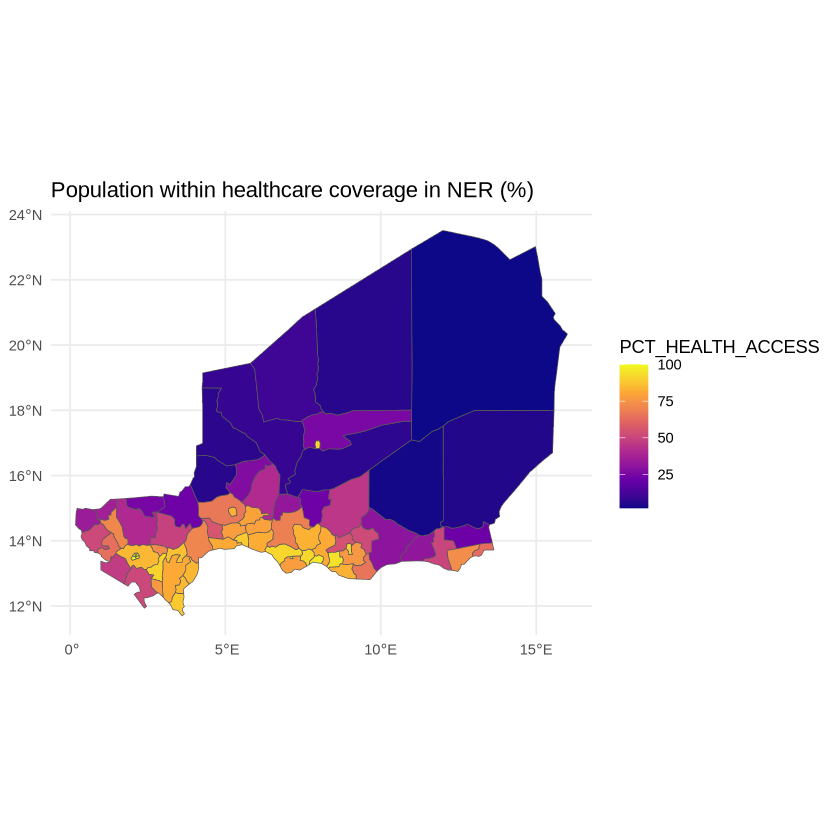

In [12]:
print(pop_covered_plot)

In [13]:
# Save as .png file

pop_covered_plot_filename <- glue("{COUNTRY_CODE}_{admin_level}_{data_source}_{reference_year}_pop_health_covered_plot.png")

ggsave(file.path(OUTPUT_PLOTS_PATH, pop_covered_plot_filename), plot = pop_covered_plot)

Saving 7 x 7 in image


Saving 7 x 7 in image


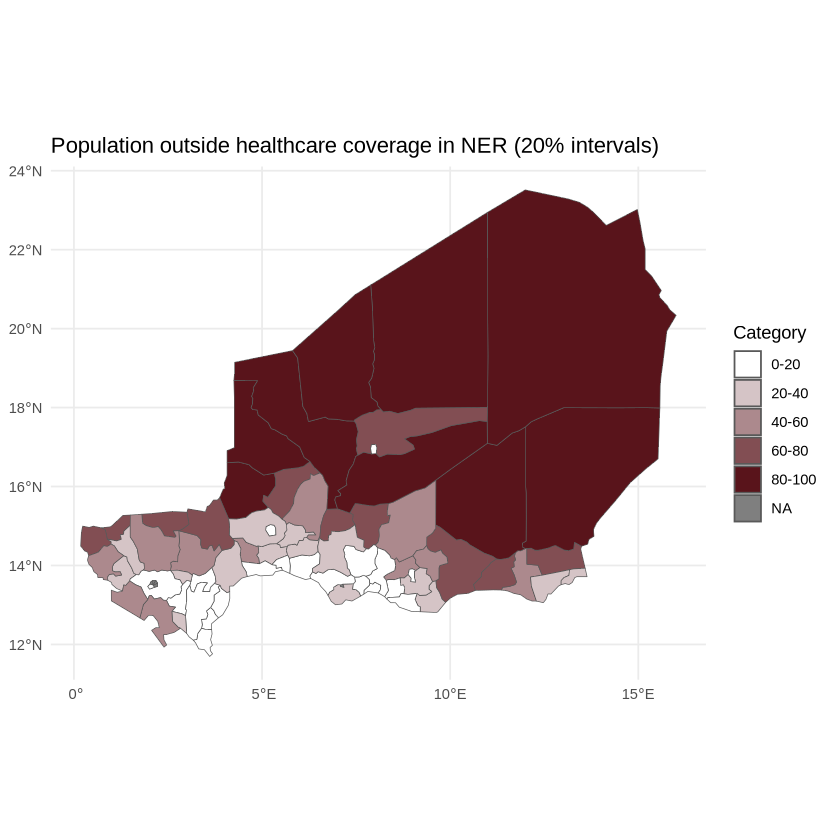

In [14]:
uncovered_cat_palette <- colorRampPalette(c("white", "#59141B"))(5)

cat_uncovered_plot <- ggplot(plot_data) +
  geom_sf(aes(fill = CAT_UNCOVERED)) +
  scale_fill_manual(values = uncovered_cat_palette, drop = FALSE) +
  theme_minimal() +
  labs(title = glue("Population outside healthcare coverage in {COUNTRY_CODE} (20% intervals)"),
       fill = "Category")

print(cat_uncovered_plot)

cat_uncovered_plot_filename <- glue("{COUNTRY_CODE}_{admin_level}_{data_source}_{reference_year}_cat_pop_health_uncovered_plot.png")

ggsave(file.path(OUTPUT_PLOTS_PATH, cat_uncovered_plot_filename), plot = cat_uncovered_plot)